In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm


In [11]:
# Load the Amazon fine food reviews dataset
data = pd.read_csv('Reviews.csv')
data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [12]:
# Label positive and negative reviews
data['sentiment'] = data['Score'].apply(lambda x: 1 if x > 3 else 0)

# Filter to include only 'Text' and 'sentiment' columns
data = data[['Text', 'sentiment']]

# Drop any rows with missing values
data = data.dropna()


In [13]:


# Check if there are enough samples in train_data
train_data_size = min(len(train_data), 10000)
val_data_size = min(len(val_data), 2000)
test_data_size = min(len(test_data), 2000)

# Sample accordingly
train_data = train_data.sample(train_data_size, random_state=42)
val_data = val_data.sample(val_data_size, random_state=42)
test_data = test_data.sample(test_data_size, random_state=42)



In [14]:
# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Set embedding dimension
embedding_dim = 100


In [15]:
# Define the maximum number of words in a review
max_words = 200  # Adjust based on memory limitations

# Initialize Tokenizer and fit on training text
tokenizer = Tokenizer(num_words=5000)  # Use top 5000 words
tokenizer.fit_on_texts(train_data['Text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['Text'])
val_sequences = tokenizer.texts_to_sequences(val_data['Text'])
test_sequences = tokenizer.texts_to_sequences(test_data['Text'])

# Pad sequences to ensure uniform length
X_train = pad_sequences(train_sequences, maxlen=max_words, padding='post')
X_val = pad_sequences(val_sequences, maxlen=max_words, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_words, padding='post')

# Define labels
y_train = train_data['sentiment'].values
y_val = val_data['sentiment'].values
y_test = test_data['sentiment'].values


In [16]:
# Initialize embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i > 5000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [17]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('embedding_matrix.npy', embedding_matrix)


# Build the Models

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

## LSTM CODE

In [19]:
def build_lstm_model(embedding_matrix, max_words, embedding_dim=100):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_dim,
                  weights=[embedding_matrix], input_length=max_words, trainable=False),
        LSTM(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## GRU CODE

In [20]:
def build_gru_model(embedding_matrix, max_words, embedding_dim=100):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_dim,
                  weights=[embedding_matrix], input_length=max_words, trainable=False),
        GRU(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## **training both models**

In [21]:
# Parameters
epochs = 10
batch_size = 64

# LSTM Model
lstm_model = build_lstm_model(embedding_matrix, max_words)
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=epochs, batch_size=batch_size)

# GRU Model
gru_model = build_gru_model(embedding_matrix, max_words)
gru_history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size)


Epoch 1/10
132/132 [==============================] - 14s 95ms/step - loss: 0.6929 - accuracy: 0.5031 - val_loss: 0.6913 - val_accuracy: 0.5160
Epoch 2/10
132/132 [==============================] - 13s 97ms/step - loss: 0.6907 - accuracy: 0.5124 - val_loss: 0.6911 - val_accuracy: 0.5165
Epoch 3/10
132/132 [==============================] - 12s 91ms/step - loss: 0.6891 - accuracy: 0.5110 - val_loss: 0.6922 - val_accuracy: 0.5125
Epoch 4/10
132/132 [==============================] - 12s 92ms/step - loss: 0.6886 - accuracy: 0.5169 - val_loss: 0.6900 - val_accuracy: 0.5170
Epoch 5/10
132/132 [==============================] - 12s 91ms/step - loss: 0.6871 - accuracy: 0.5196 - val_loss: 0.6903 - val_accuracy: 0.5170
Epoch 6/10
132/132 [==============================] - 12s 91ms/step - loss: nan - accuracy: 0.5102 - val_loss: nan - val_accuracy: 0.4960
Epoch 7/10
132/132 [==============================] - 12s 93ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.4960
Epoc

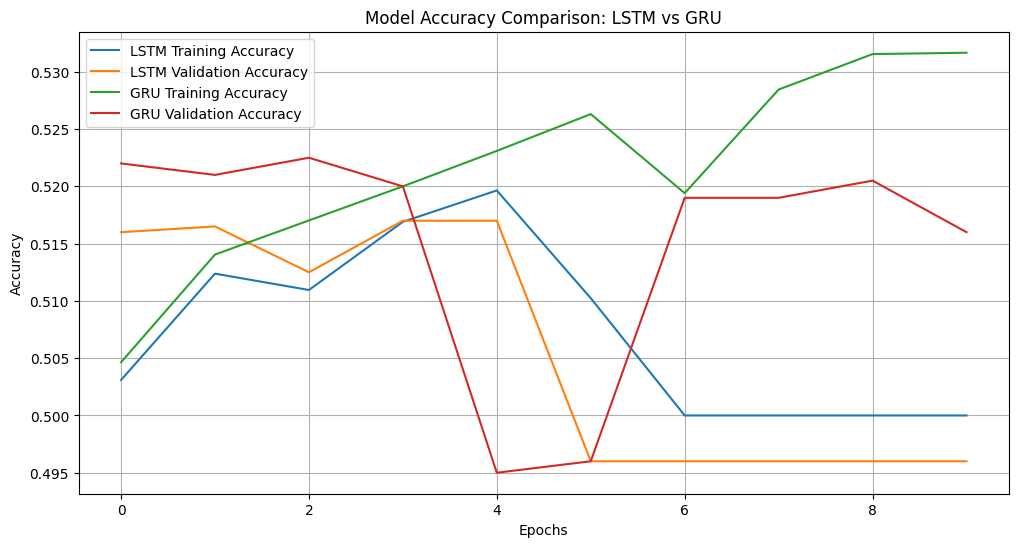

In [22]:
# Plot accuracy comparison
plt.figure(figsize=(12, 6))

# LSTM Accuracy
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')

# GRU Accuracy
plt.plot(gru_history.history['accuracy'], label='GRU Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Validation Accuracy')

# Labels and Legends
plt.title('Model Accuracy Comparison: LSTM vs GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## GRU Model with Varying RNN Sizes and Layers

In [23]:
def build_gru_model(embedding_matrix, max_words, rnn_size=64, layers=1, embedding_dim=100):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_words, trainable=False))
    
    # Add GRU layers
    for _ in range(layers - 1):
        model.add(GRU(rnn_size, activation='relu', return_sequences=True))
    
    model.add(GRU(rnn_size, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [29]:
# Parameters
epochs = 5
batch_size = 64
rnn_sizes = [32,64,128]
layer_counts = [1]
results = {}

In [30]:
for rnn_size in rnn_sizes:
    for layers in layer_counts:
        print("\n***************************************************************************\n")
        print(f"\nTraining GRU model with RNN size = {rnn_size} and layers = {layers} ...\n")
        
        # Build and train model
        model = build_gru_model(embedding_matrix, max_words, rnn_size=rnn_size, layers=layers)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=1)
        
        # Save accuracy for each configuration
        train_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        results[(rnn_size, layers)] = (train_accuracy, val_accuracy)
        
        # Print accuracy results
        print(f"\n RNN Size: {rnn_size}, Layers: {layers} - Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f} \n")



***************************************************************************


Training GRU model with RNN size = 32 and layers = 1 ...

Epoch 1/5
132/132 [==============================] - 9s 56ms/step - loss: 0.6934 - accuracy: 0.4957 - val_loss: 0.6912 - val_accuracy: 0.5195
Epoch 2/5
132/132 [==============================] - 7s 52ms/step - loss: 0.6911 - accuracy: 0.5087 - val_loss: 0.6906 - val_accuracy: 0.5205
Epoch 3/5
132/132 [==============================] - 7s 53ms/step - loss: 0.6893 - accuracy: 0.5156 - val_loss: 0.6903 - val_accuracy: 0.5200
Epoch 4/5
132/132 [==============================] - 7s 52ms/step - loss: 0.6872 - accuracy: 0.5174 - val_loss: 0.6908 - val_accuracy: 0.5180
Epoch 5/5
132/132 [==============================] - 7s 52ms/step - loss: 0.6849 - accuracy: 0.5192 - val_loss: 0.6903 - val_accuracy: 0.4990

 RNN Size: 32, Layers: 1 - Train Accuracy: 0.5192, Validation Accuracy: 0.4990 


**********************************************************************

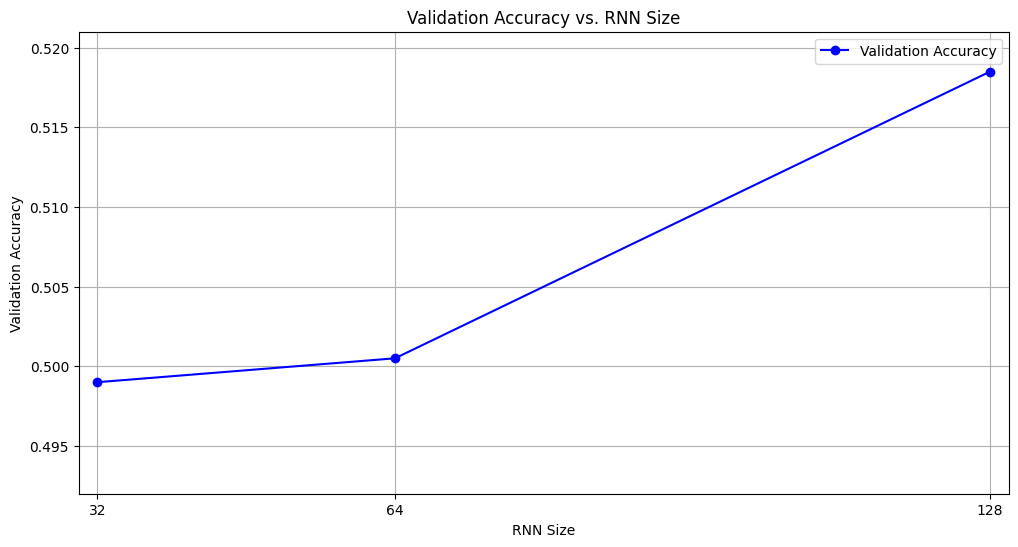

In [57]:
# Plot validation accuracy vs. RNN size
plt.figure(figsize=(12, 6))

# Define RNN sizes and extract corresponding validation accuracies
rnn_sizes = [32, 64, 128]
val_accuracies = [results[(rnn_size, 1)][1] for rnn_size in rnn_sizes]  # Assuming layer count is fixed at 1

# Plot RNN size vs. validation accuracy
plt.plot(rnn_sizes, val_accuracies, marker='o', color='b', label='Validation Accuracy')

plt.xlabel('RNN Size')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. RNN Size')
plt.ylim(0.492, 0.521)  # Set y-axis limits for better visualization
plt.xlim(30, 130)      # Set x-axis limits to cover the RNN sizes
plt.xticks(rnn_sizes)   # Ensure x-axis only shows the RNN sizes (32, 64, 128)
plt.legend()
plt.grid()
plt.show()


## Train Models with Varying Number of Stack Layers (2,3,4)

In [36]:
# Parameters
epochs = 3
batch_size = 64
stack_layers = [2, 3, 4]
best_rnn_size = 128
stacked_results = {}

for layers in stack_layers:
    print("***************************************************************************************")
    print(f"\nTraining GRU model with RNN size = {best_rnn_size} and stack layers = {layers} ... \n")
    
    # Build and train the model
    model = build_gru_model(embedding_matrix, max_words, rnn_size=best_rnn_size, layers=layers)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Save validation accuracy for each configuration
    val_accuracy = history.history['val_accuracy'][-1]
    stacked_results[layers] = val_accuracy
    
    # Print validation accuracy result
    print(f"\n RNN Size: {best_rnn_size}, Stack Layers: {layers} - Validation Accuracy: {val_accuracy:.4f} \n ")


***************************************************************************************

Training GRU model with RNN size = 128 and stack layers = 2 ... 

Epoch 1/3
132/132 [==============================] - 52s 374ms/step - loss: 0.6929 - accuracy: 0.5088 - val_loss: 0.6915 - val_accuracy: 0.5200
Epoch 2/3
132/132 [==============================] - 51s 388ms/step - loss: 0.6917 - accuracy: 0.5100 - val_loss: 0.6907 - val_accuracy: 0.5200
Epoch 3/3
132/132 [==============================] - 54s 410ms/step - loss: 0.6890 - accuracy: 0.5140 - val_loss: 0.6904 - val_accuracy: 0.5190

 RNN Size: 128, Stack Layers: 2 - Validation Accuracy: 0.5190 
 
***************************************************************************************

Training GRU model with RNN size = 128 and stack layers = 3 ... 

Epoch 1/3
132/132 [==============================] - 227s 2s/step - loss: 0.6928 - accuracy: 0.5118 - val_loss: 0.6928 - val_accuracy: 0.4960
Epoch 2/3
132/132 [==============================]

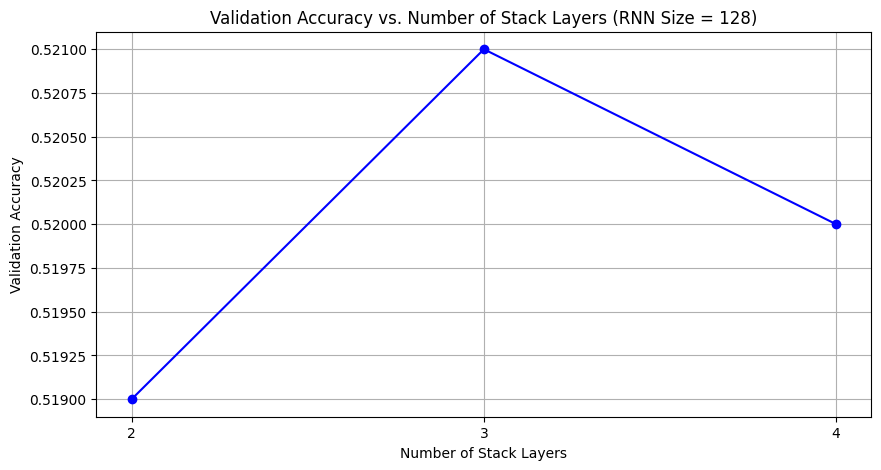

In [37]:
# Plot accuracy vs. number of stack layers
plt.figure(figsize=(10, 5))

# Extract and plot data
layers = list(stacked_results.keys())
val_accuracies = list(stacked_results.values())

plt.plot(layers, val_accuracies, marker='o', color='b')
plt.xticks(layers)  # Ensure only integer labels on x-axis
plt.xlabel('Number of Stack Layers')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Stack Layers (RNN Size = 128)')
plt.grid()
plt.show()


## Dropout and Regularization included

## We'll add a dropout layer with a rate of 0.1 and use L2 regularization in the Dense layer.


In [38]:
from tensorflow.keras.regularizers import l2

def build_gru_model_with_regularization(embedding_matrix, max_words, rnn_size=128, layers=3, embedding_dim=100, dropout_rate=0.1):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_words, trainable=False))
    
    # Add GRU layers with dropout
    for _ in range(layers - 1):
        model.add(GRU(rnn_size, activation='relu', return_sequences=True))
        model.add(Dropout(dropout_rate))
    
    model.add(GRU(rnn_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    # Final Dense layer with L2 regularization
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [39]:
# Parameters
epochs = 3
batch_size = 64

# Build and train the regularized model
regularized_model = build_gru_model_with_regularization(embedding_matrix, max_words, rnn_size=128, layers=3)
regularized_history = regularized_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                            epochs=epochs, batch_size=batch_size, verbose=1)


Epoch 1/3
132/132 [==============================] - 190s 1s/step - loss: 0.7027 - accuracy: 0.5118 - val_loss: 0.6954 - val_accuracy: 0.5200
Epoch 2/3
132/132 [==============================] - 188s 1s/step - loss: 0.6942 - accuracy: 0.5110 - val_loss: 0.6921 - val_accuracy: 0.5195
Epoch 3/3
132/132 [==============================] - 188s 1s/step - loss: 0.6927 - accuracy: 0.5131 - val_loss: 0.6921 - val_accuracy: 0.5205


In [40]:
train_accuracy = regularized_history.history['accuracy'][-1]
val_accuracy = regularized_history.history['val_accuracy'][-1]

print(f"Best Model with Regularization - Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Best Model with Regularization - Train Accuracy: 0.5131, Validation Accuracy: 0.5205


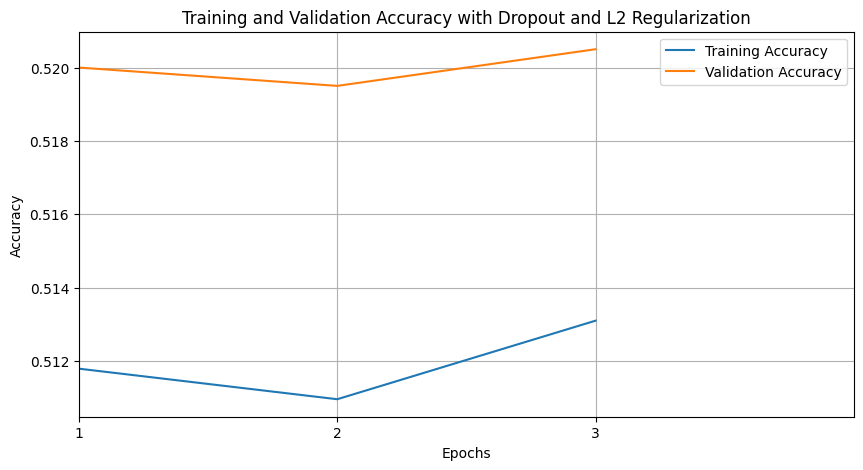

In [52]:
# Plot accuracy with regularization
plt.figure(figsize=(10, 5))

plt.plot(regularized_history.history['accuracy'], label='Training Accuracy')
plt.plot(regularized_history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Dropout and L2 Regularization')
plt.xlim(1, 3)  # Adjust x-axis limit
plt.xticks(range(0, 3), labels=['1', '2', '3'])
# plt.xlim(0,3)
plt.legend()
plt.grid()
plt.show()
